# Load Packages

In [9]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Load and prepare data

In [10]:
data = pd.read_csv("../../data/processed/training_numeric_cleaned.csv", sep="\t")

X = data.drop(columns=["ActualTOW"])
y = data["ActualTOW"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

# Model definition

In [11]:


param_grid = {
    "regressor__n_estimators": [50, 100, 200],
    "regressor__max_depth": [5, 10, 20],
    "regressor__min_samples_split": [2, 5],
    "regressor__min_samples_leaf": [1, 2]
}

base_model = RandomForestRegressor(random_state=42)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", base_model)
])

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Best parameters:", grid_search.best_params_)
print(f"✅ Final model RMSE: {rmse:.2f} | MAE: {mae:.2f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
✅ Final model RMSE: 828.78 | MAE: 605.29


# Plot preditions vs true

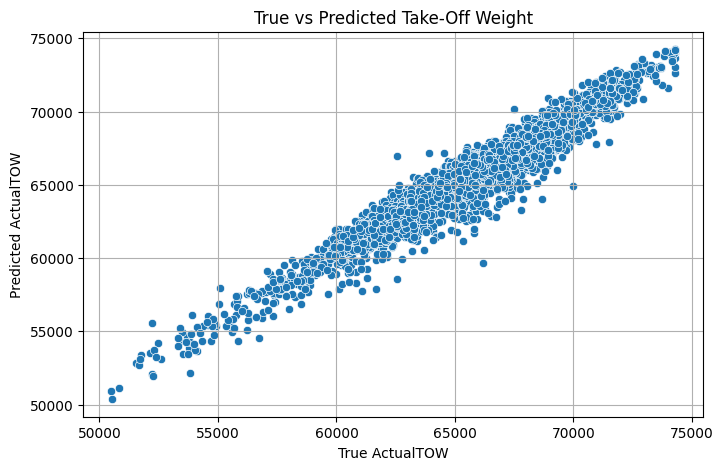

In [12]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("True ActualTOW")
plt.ylabel("Predicted ActualTOW")
plt.title("True vs Predicted Take-Off Weight")
plt.grid(True)
plt.show()